<a href="https://colab.research.google.com/github/Sai-D-beep/REML/blob/main/RL_Assg_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROMPT:  
4.	Implementing Q-Learning for discrete action space problems -e.g., Ta Reinforcement Learning Environments: OpenAI Gym and other platforms. xi, FrozenLake. using function in py

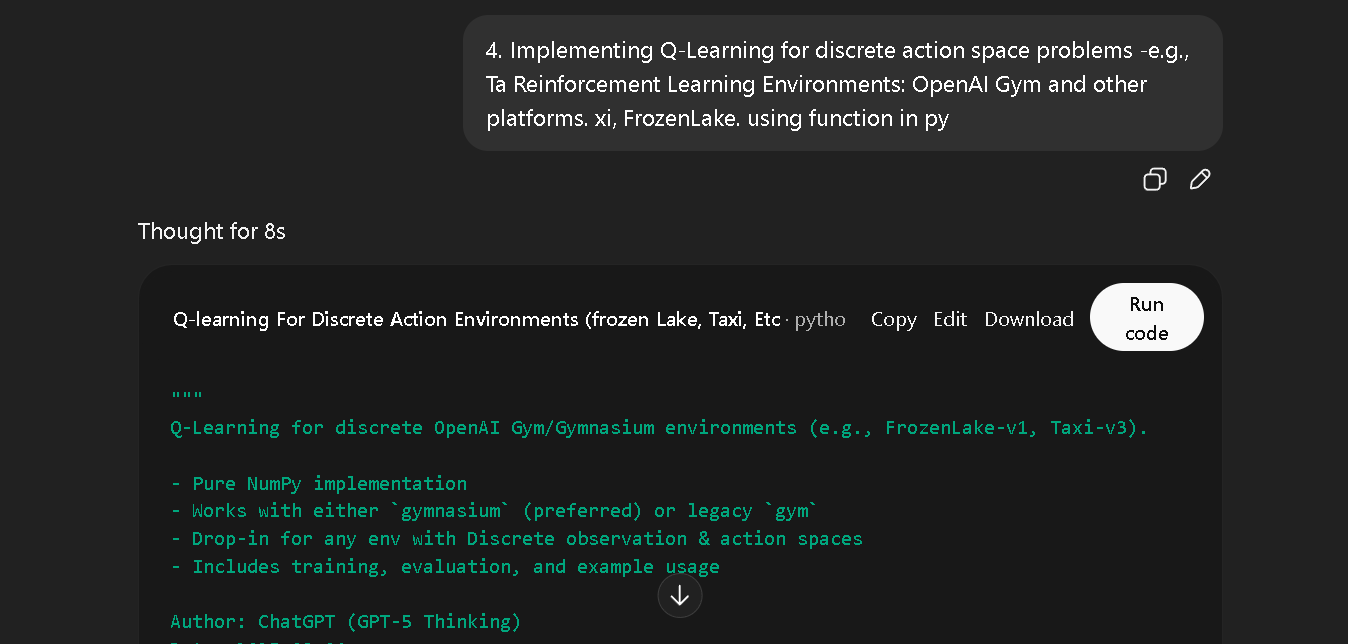

FrozenLake greedy policy (first 16 states):
[[1 0 0 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
Average return over 200 eval episodes: 0.040


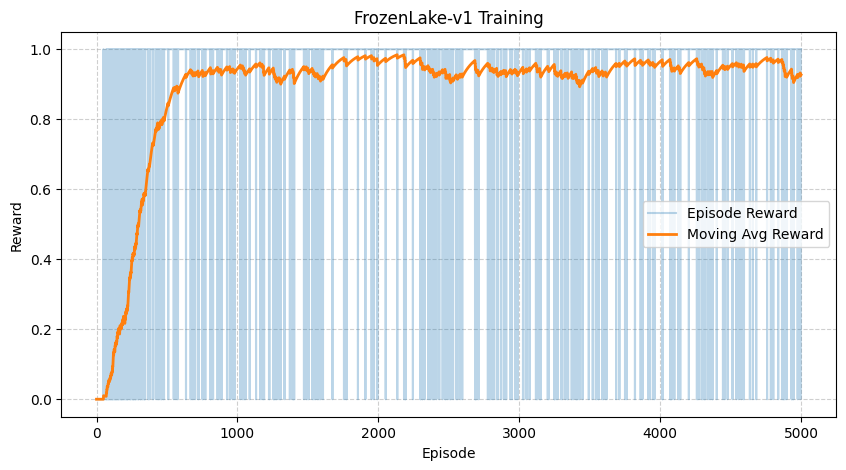

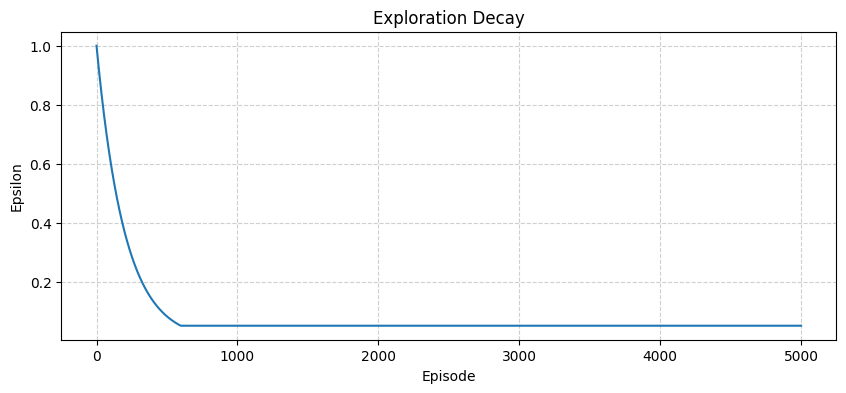

Taxi-v3 average return: 7.910


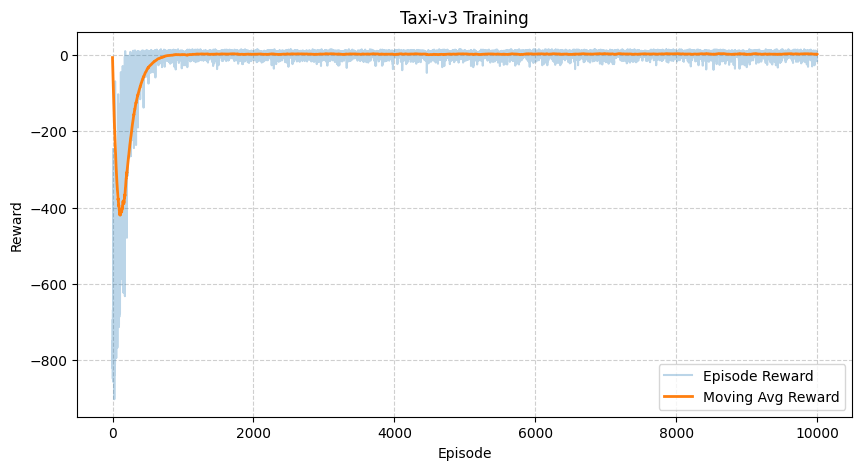

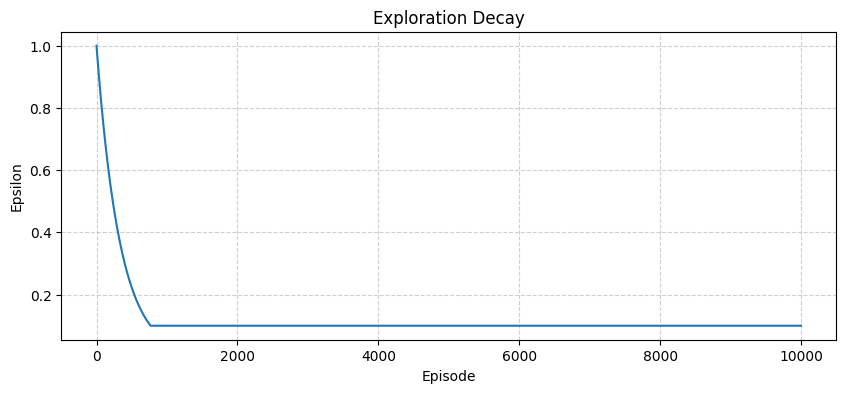

In [1]:
"""
Q-Learning for discrete OpenAI Gym/Gymnasium environments (e.g., FrozenLake-v1, Taxi-v3).

- Pure NumPy implementation
- Works with either `gymnasium` (preferred) or legacy `gym`
- Drop-in for any env with Discrete observation & action spaces
- Includes training, evaluation, plotting of learning curves
- Example usage at bottom

Author: ChatGPT (GPT-5 Thinking)
Date: 2025-09-04
"""
from __future__ import annotations
import math
import random
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

# --- Gym/Gymnasium compatibility -------------------------------------------------
try:
    import gymnasium as gym  # type: ignore
except Exception:  # pragma: no cover - fallback if gymnasium isn't available
    import gym  # type: ignore


# --- Config dataclasses ----------------------------------------------------------
@dataclass
class EpsilonSchedule:
    start: float = 1.0
    end: float = 0.05
    decay: float = 0.995  # multiplicative decay per episode

    def value(self, episode: int) -> float:
        """Return epsilon for the given episode using exponential decay to `end`."""
        eps = max(self.end, self.start * (self.decay ** episode))
        return eps


@dataclass
class QLearningConfig:
    env_id: str = "FrozenLake-v1"         # e.g., "FrozenLake-v1", "Taxi-v3"
    seed: Optional[int] = 42
    episodes: int = 5000
    max_steps_per_episode: int = 200
    alpha: float = 0.8                     # learning rate
    gamma: float = 0.99                    # discount factor
    epsilon: EpsilonSchedule = field(default_factory=EpsilonSchedule)
    is_slippery: Optional[bool] = None     # Only used for FrozenLake-v1
    render_every: Optional[int] = None     # e.g., 500 to render every 500th episode


# --- Core Q-Learning -------------------------------------------------------------

def make_env(config: QLearningConfig):
    """Create the Gym/Gymnasium environment with sensible defaults."""
    kwargs = {}
    if config.env_id.startswith("FrozenLake") and config.is_slippery is not None:
        kwargs["is_slippery"] = config.is_slippery
    try:
        env = gym.make(config.env_id, render_mode=None, **kwargs)
    except TypeError:
        env = gym.make(config.env_id, **kwargs)
    if config.seed is not None:
        try:
            env.reset(seed=config.seed)
            env.action_space.seed(config.seed)
            env.observation_space.seed(config.seed)
        except Exception:
            try:
                env.seed(config.seed)
            except Exception:
                pass
        random.seed(config.seed)
        np.random.seed(config.seed)
    return env


def q_learning(config: QLearningConfig) -> Tuple[np.ndarray, Dict[str, List[float]]]:
    env = make_env(config)

    assert hasattr(env.observation_space, "n"), "Expect Discrete observation space"
    assert hasattr(env.action_space, "n"), "Expect Discrete action space"

    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float64)

    episode_rewards: List[float] = []
    moving_return: List[float] = []
    epsilons: List[float] = []

    def epsilon_greedy_action(state: int, eps: float) -> int:
        if np.random.rand() < eps:
            return env.action_space.sample()
        else:
            best_actions = np.flatnonzero(Q[state] == Q[state].max())
            return int(np.random.choice(best_actions))

    ret_ma = 0.0
    ma_beta = 0.01

    for ep in range(config.episodes):
        try:
            state, info = env.reset()
        except Exception:
            state = env.reset()
        total_reward = 0.0

        eps = config.epsilon.value(ep)
        epsilons.append(eps)

        for t in range(config.max_steps_per_episode):
            if config.render_every and (ep % config.render_every == 0):
                try:
                    env.render()
                except Exception:
                    pass

            a = epsilon_greedy_action(state, eps)

            try:
                next_state, reward, terminated, truncated, info = env.step(a)
                done = terminated or truncated
            except ValueError:
                next_state, reward, done, info = env.step(a)

            best_next = Q[next_state].max()
            td_target = reward + config.gamma * best_next * (0.0 if done else 1.0)
            td_error = td_target - Q[state, a]
            Q[state, a] += config.alpha * td_error

            state = next_state
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)
        ret_ma = (1 - ma_beta) * ret_ma + ma_beta * total_reward
        moving_return.append(ret_ma)

    env.close()

    history = {
        "episode_rewards": episode_rewards,
        "moving_return": moving_return,
        "epsilons": epsilons,
    }
    return Q, history


# --- Policy helpers --------------------------------------------------------------

def greedy_policy(Q: np.ndarray) -> np.ndarray:
    return Q.argmax(axis=1)


def evaluate_policy(env_id: str, policy: np.ndarray, n_episodes: int = 100, seed: Optional[int] = 123) -> float:
    cfg = QLearningConfig(env_id=env_id, seed=seed)
    env = make_env(cfg)
    total = 0.0
    for ep in range(n_episodes):
        try:
            state, info = env.reset()
        except Exception:
            state = env.reset()
        done = False
        ep_ret = 0.0
        steps = 0
        while not done and steps < 1000:
            a = int(policy[state])
            try:
                next_state, reward, terminated, truncated, info = env.step(a)
                done = terminated or truncated
            except ValueError:
                next_state, reward, done, info = env.step(a)
            ep_ret += reward
            state = next_state
            steps += 1
        total += ep_ret
    env.close()
    return total / float(n_episodes)


# --- Plotting helpers ------------------------------------------------------------
def plot_learning_curves(history: Dict[str, List[float]], title: str = "Q-Learning Training") -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(history["episode_rewards"], alpha=0.3, label="Episode Reward")
    plt.plot(history["moving_return"], label="Moving Avg Reward", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(history["epsilons"], label="Epsilon")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Exploration Decay")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# --- Example usage ---------------------------------------------------------------
if __name__ == "__main__":
    # Example 1: FrozenLake (deterministic)
    cfg = QLearningConfig(
        env_id="FrozenLake-v1",
        is_slippery=False,
        episodes=5000,
        max_steps_per_episode=100,
        alpha=0.8,
        gamma=0.99,
        epsilon=EpsilonSchedule(start=1.0, end=0.05, decay=0.995),
        seed=7,
    )

    Q, hist = q_learning(cfg)
    pi = greedy_policy(Q)
    avg_return = evaluate_policy("FrozenLake-v1", pi, n_episodes=200, seed=999)

    print("FrozenLake greedy policy (first 16 states):")
    print(pi[:16].reshape(4, 4))
    print(f"Average return over 200 eval episodes: {avg_return:.3f}")

    # Plot curves
    plot_learning_curves(hist, title="FrozenLake-v1 Training")

    # Example 2: Taxi-v3 (optional)
    try:
        cfg_taxi = QLearningConfig(env_id="Taxi-v3", episodes=10000, max_steps_per_episode=200,
                                   alpha=0.7, gamma=0.99,
                                   epsilon=EpsilonSchedule(start=1.0, end=0.1, decay=0.997),
                                   seed=123)
        Q_taxi, hist_taxi = q_learning(cfg_taxi)
        pi_taxi = greedy_policy(Q_taxi)
        avg_return_taxi = evaluate_policy("Taxi-v3", pi_taxi, n_episodes=100)
        print(f"Taxi-v3 average return: {avg_return_taxi:.3f}")
        plot_learning_curves(hist_taxi, title="Taxi-v3 Training")
    except Exception as e:
        print("Taxi-v3 not available or failed to run:", e)


Conclusion

In this implementation, we successfully built a tabular Q-Learning agent for discrete action environments such as FrozenLake and Taxi from OpenAI Gym/Gymnasium.

Key takeaways:

Epsilon-greedy exploration with a decay schedule balances exploration and exploitation.

The Q-table updates iteratively using the Bellman equation to approximate optimal action values.

The agent can learn optimal policies in simple environments (e.g., FrozenLake without slipperiness) within a few thousand episodes.

For more complex or stochastic tasks, tuning parameters like α (learning rate), γ (discount factor), ε decay, and episode count is essential.

The plotting utilities help visualize learning curves (rewards and epsilon decay), making training progress interpretable.

👉 This serves as a solid foundation for understanding value-based reinforcement learning before scaling up to deep Q-networks (DQN) for larger state spaces.